Import libraries

In [338]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from itertools import cycle
from numpy import interp
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, space_eval
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
%matplotlib inline
%run ./classifier_evaluation.ipynb

import dataset

In [339]:
pd.set_option('display.max_columns', None)  # Show all columns
raw_data = pd.read_csv('GENEPY_JULY2021_all.csv')

raw_data.info()

data_1 = raw_data.copy() # Create data copy

data_1 = data_1.infer_objects()  # Automatically correct the data type of each column

data_1.info()

raw_data_2 = pd.read_csv('fuentes_falsePos.csv')

raw_data_2.info()

data_2 = raw_data_2.copy() # Create data copy

data_2 = data_2.infer_objects()  # Automatically correct the data type of each column

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 135.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 135.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   a1/3GTP  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   a1/3GTP  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB


In [340]:
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'IBDU'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'NOT IBD'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'UC/CD'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'UNKNOWN'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'Patchy colitis'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'Other'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'IBDU '].index)

Remove the false-positive signal features from the lists

In [341]:
fuentes_falsePos_list = list(data_2['a1/3GTP'])[0:]
features_list = list(data_1.columns)[1:]
c = 0
for feature in features_list:
    for fuentes_falsePos in fuentes_falsePos_list:
        if(feature == fuentes_falsePos):
            c+=1
            #print(c)
            #print(feature)
            #print(fuentes_falsePos)
            data_1 = data_1.drop([feature], axis=1)
            break

Fisher ratio - feature selection

In [342]:
X2 =  data_1[data_1.columns[0:]]
X2.loc[X2["confirmed_diag"] == "CD", "confirmed_diag"] = 1
X2.loc[X2["confirmed_diag"] == "UC", "confirmed_diag"] = 0
y2 = X2['confirmed_diag']
y2 = y2.astype('int')

data_UC = X2[X2.confirmed_diag == 0]
data_CD = X2[X2.confirmed_diag == 1]

In [343]:
features_list = list(X2.columns)[1:]

fisher_score_list = []
for feature in features_list:
    mUC_feature_mean = data_UC[feature].mean()
    mCD_feature_mean = data_CD[feature].mean()
    sUC_feature_std = data_UC[feature].std()
    sCD_feature_std = data_CD[feature].std()
    m_feature_mean = (mUC_feature_mean - mCD_feature_mean)**2
    s_feature_std = sUC_feature_std**2 + sCD_feature_std**2
    if s_feature_std == 0:
        # 0/0 type also returns nan
        m_fisher_score = 0
    else:
        # Calculate Fisher score
        m_fisher_score = m_feature_mean / s_feature_std
        #Fisher score value added to the list
        #m_fisher_score = '{0:.20f}'.format(m_fisher_score)
    fisher_score_list.append(m_fisher_score)

In [344]:
fisher_score_list

[0.00037306716689840665,
 8.098878491057759e-06,
 4.978539307409414e-05,
 0.0001300677425960577,
 2.5816242833409168e-05,
 0.0012470017164145071,
 0.008918154976319807,
 0.0009889164677309413,
 0.00014436687038708976,
 0.00032582546301016864,
 0.0029866740908336895,
 0.0013723692303202711,
 0.00032501090042351166,
 1.8425324016625922e-05,
 0.007267076286618172,
 0.00046991302347622007,
 0.001884826365549816,
 0.0009158062882019903,
 0.00044102844243587954,
 1.1734767325987975e-05,
 0.0035426056110261363,
 0.00021994832797445277,
 0.003548326102120671,
 0.0001102108065184841,
 0.0012490621630820485,
 5.653480818193687e-05,
 0.00021700000043394876,
 0.004147784413841603,
 0.006464307335506229,
 0.0004509757155692005,
 1.5759106026580507e-06,
 0.0015483671441012235,
 0.00011640645270790642,
 0.002195692623054229,
 0.0021988372951870917,
 0.00178315311797683,
 0.0007411075794003546,
 0.0063177718070162965,
 3.5862966151919144e-09,
 0.00015305057514197304,
 0.0027774289185321576,
 0.0001139

In [345]:
sorted_fisher_score_list = sorted(enumerate(fisher_score_list), key=lambda x: x[1], reverse = True)
sorted_fisher_score_list

[(9271, 0.12490589575305075),
 (1040, 0.045248182691289926),
 (5656, 0.03679659230853018),
 (6007, 0.03260544987280489),
 (11024, 0.03055308191606858),
 (4662, 0.030431666982832384),
 (177, 0.030201138782154847),
 (8642, 0.028682150165702358),
 (1208, 0.028016310485821046),
 (9512, 0.027964932571787005),
 (2604, 0.02574497569334671),
 (8926, 0.024580467542812248),
 (10545, 0.024424672531764065),
 (13386, 0.024162307801648106),
 (8155, 0.02397669092577833),
 (399, 0.023840503083339938),
 (4430, 0.023432907506831552),
 (14775, 0.02301721324802527),
 (3458, 0.0226862084864173),
 (891, 0.02240957765061912),
 (8218, 0.022370522180349732),
 (7582, 0.021820503216440586),
 (13636, 0.021799008745868022),
 (12875, 0.021773120076742605),
 (15709, 0.021437307452840875),
 (256, 0.021157357101317494),
 (4421, 0.02093983318507768),
 (1731, 0.020807153948122263),
 (8592, 0.020535781297448506),
 (871, 0.020477890213915956),
 (9572, 0.020188513123328155),
 (14776, 0.02018210104667327),
 (9404, 0.0201179

In [346]:
idx = [i[0] for i in sorted_fisher_score_list]
nums = [i[1] for i in sorted_fisher_score_list]

top_5_genes = [features_list[i] for i in idx[0:5]]

top_10_genes = [features_list[i] for i in idx[0:10]]

top_20_genes = [features_list[i] for i in idx[0:20]]

top_50_genes = [features_list[i] for i in idx[0:50]]

top_100_genes = [features_list[i] for i in idx[0:100]]

print("top_5_genes:\n", top_5_genes)
print("top_10_genes\n", top_10_genes)
print("top_20_genes\n", top_20_genes)
print("top_50_genes\n", top_50_genes)
print("top_100_genes\n", top_100_genes)

top_5_genes:
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7']
top_10_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50']
top_20_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50', 'CFAP58', 'NANS', 'PNKD', 'SPTSSB', 'MET', 'AGO1', 'ERAP1', 'TRIM63', 'CYP4F11', 'ARHGEF7']
top_50_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50', 'CFAP58', 'NANS', 'PNKD', 'SPTSSB', 'MET', 'AGO1', 'ERAP1', 'TRIM63', 'CYP4F11', 'ARHGEF7', 'MGAT2', 'LNX2', 'SULT1A1', 'SLC4A2', 'ZBTB20', 'ADAMTS20', 'EPS15L1', 'C2orf69', 'MRPL36', 'ARHGEF10L', 'ODF2L', 'TRIM64C', 'NRN1L', 'PSMD13', 'ARF3', 'ADAM29', 'BRINP2', 'AURKA', 'TNFAIP8', 'CRISP2', 'THNSL1', 'USP40', 'XPC', 'SV2C', 'FNBP1', 'LRP8', 'ARAP1', 'ITPR3', 'RNF19B', 'CX3CR1']
top_100_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50', 'CFAP58', 'NANS', 'PNKD', 'SPTSSB', 'MET', 

In [347]:

X2= X2.drop(['confirmed_diag'], axis=1)
#X2 = X2.values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.30, random_state = 42)
X2_5_train = X2_train.loc[:, top_5_genes].values
X2_5_test = X2_test.loc[:, top_5_genes].values
y2_train = y2_train.astype('int').values
y2_test = y2_test.astype('int').values

top 5 genes

SVM

In [348]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X2_5_train, y2_train, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [00:42<00:00,  2.38trial/s, best loss: 0.3132913735653462]


In [349]:
# step4: 打印结果
print(best)

{'C': 4.827247339234803, 'gamma': 1, 'kernel': 1, 'probability': 0}


In [350]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_5 = svm.SVC(C = 4.827247339234803, kernel='rbf', probability=True, gamma='auto', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

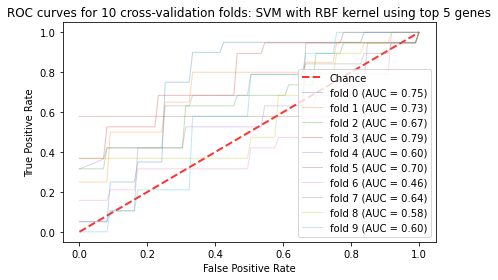

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

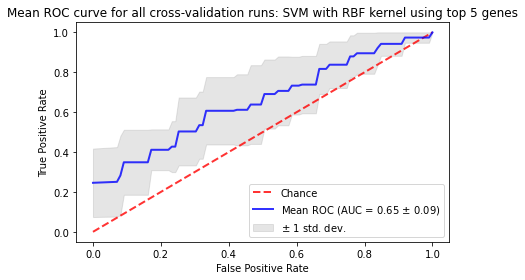

In [351]:

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_5, f1_scores_SVM_5, tprs_SVM_5, aucs_SVM_5 = evaluate_classifier(folds=10, 
                                                                        p=X2_5_test, t=y2_test, 
                                                                        classifier=SVM_classifier_5, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_5, aucs_SVM_5, 'SVM with RBF kernel using top 5 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_5, aucs_SVM_5, 'SVM with RBF kernel using top 5 genes')

RF

In [352]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_5 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_5, X2_5_train, y2_train, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [05:34<00:00,  4.18s/trial, best loss: -0.6854313217326916]


{'criterion': 1,
 'max_depth': 530.0,
 'max_features': 2,
 'min_samples_leaf': 0.01006702089375072,
 'min_samples_split': 0.3223083885421507,
 'n_estimators': 2}

In [354]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X2_5_train,y2_train)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

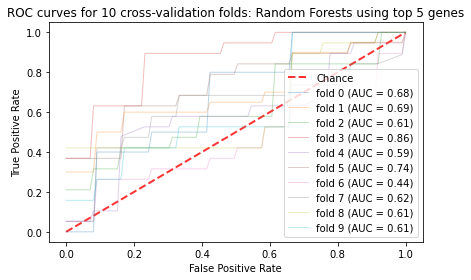

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

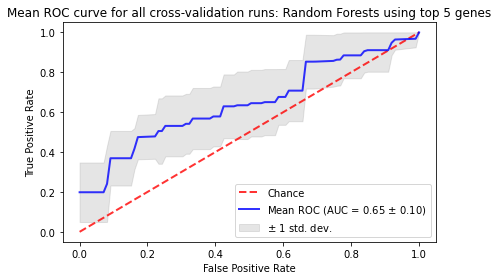

In [355]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_5, f1_scores_RF_5, tprs_RF_5, aucs_RF_5 = evaluate_classifier(folds=10, 
                                                                        p=X2_5_test, t=y2_test, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_5, aucs_RF_5, 'Random Forests using top 5 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_5, aucs_RF_5, 'Random Forests using top 5 genes')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


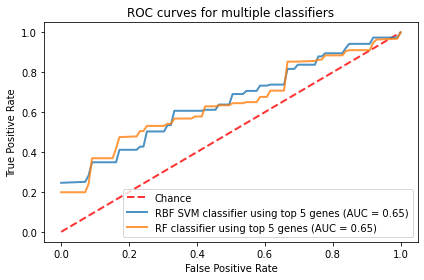

In [356]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_5, axis=0), np.mean(tprs_RF_5, axis=0))), 
                              np.array([np.mean(aucs_SVM_5), np.mean(aucs_RF_5)]), 
                              np.array(['RBF SVM classifier using top 5 genes', 'RF classifier using top 5 genes']))

top 10 genes

In [357]:
X2_10_train = X2_train.loc[:, top_10_genes].values
X2_10_test = X2_test.loc[:, top_10_genes].values

In [358]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X2_10_train, y2_train, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# step4: 打印结果
print(best)

100%|██████████| 100/100 [00:41<00:00,  2.38trial/s, best loss: 0.3037578674564976]
{'C': 5.531419505628482, 'gamma': 1, 'kernel': 0, 'probability': 0}


C:\Users\WENHAO WANG\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent arti

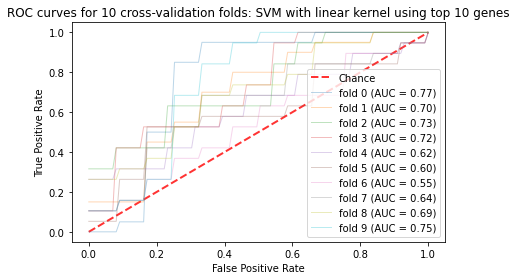

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

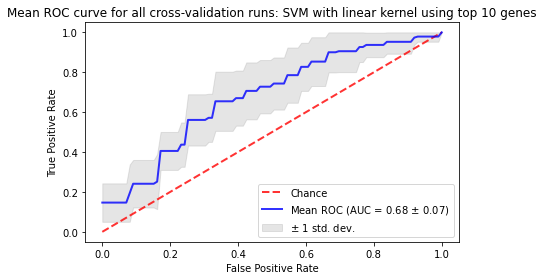

In [359]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_10 = svm.SVC(C = 5.531419505628482, kernel='linear', probability=True, gamma='auto', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_10, f1_scores_SVM_10, tprs_SVM_10, aucs_SVM_10 = evaluate_classifier(folds=10, 
                                                                        p=X2_10_test, t=y2_test, 
                                                                        classifier=SVM_classifier_10, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_10, aucs_SVM_10, 'SVM with linear kernel using top 10 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_10, aucs_SVM_10, 'SVM with linear kernel using top 10 genes')

In [360]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_10 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_10, X2_10_train, y2_train, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X2_10_train,y2_train)

100%|██████████| 80/80 [05:01<00:00,  3.76s/trial, best loss: -0.6866901147723066]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

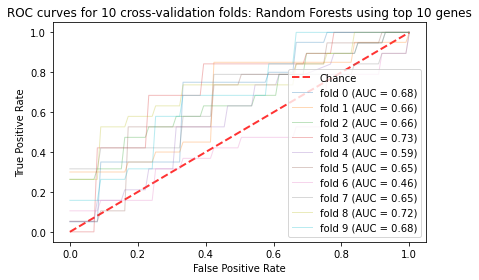

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

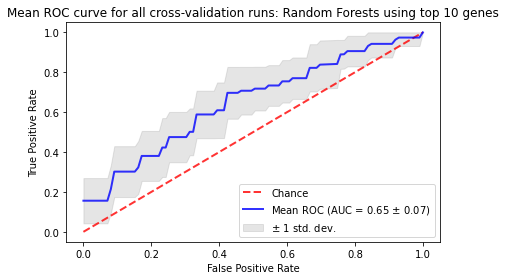

In [361]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_10, f1_scores_RF_10, tprs_RF_10, aucs_RF_10 = evaluate_classifier(folds=10, 
                                                                        p=X2_10_test, t=y2_test, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_10, aucs_RF_10, 'Random Forests using top 10 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_10, aucs_RF_10, 'Random Forests using top 10 genes')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


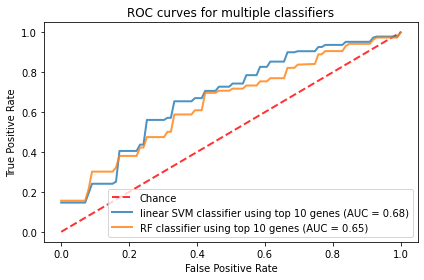

In [362]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_10, axis=0), np.mean(tprs_RF_10, axis=0))), 
                              np.array([np.mean(aucs_SVM_10), np.mean(aucs_RF_10)]), 
                              np.array(['linear SVM classifier using top 10 genes', 'RF classifier using top 10 genes']))

top 20 genes

In [365]:
X2_20_train = X2_train.loc[:, top_20_genes].values
X2_20_test = X2_test.loc[:, top_20_genes].values

In [368]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X2_20_train, y2_train, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# step4: 打印结果
print(best)

100%|██████████| 100/100 [00:49<00:00,  2.02trial/s, best loss: 0.2616068122917439]
{'C': 3.136118512023654, 'gamma': 1, 'kernel': 0, 'probability': 0}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

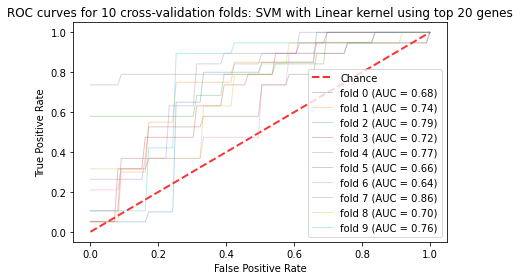

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

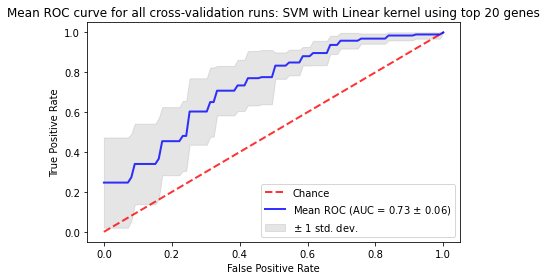

In [369]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_20 = svm.SVC(C = 3.136118512023654, kernel='linear', probability=True, gamma='auto', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_20, f1_scores_SVM_20, tprs_SVM_20, aucs_SVM_20 = evaluate_classifier(folds=10, 
                                                                        p=X2_20_test, t=y2_test, 
                                                                        classifier=SVM_classifier_20, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_20, aucs_SVM_20, 'SVM with Linear kernel using top 20 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_20, aucs_SVM_20, 'SVM with Linear kernel using top 20 genes')

In [370]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_20 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_20, X2_20_train, y2_train, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X2_20_train,y2_train)

100%|██████████| 80/80 [04:44<00:00,  3.55s/trial, best loss: -0.6662347278785635]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

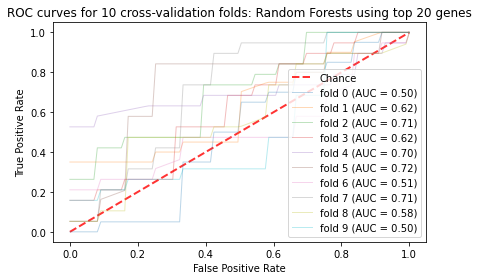

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

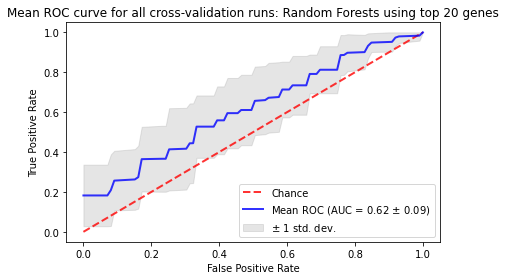

In [371]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_20, f1_scores_RF_20, tprs_RF_20, aucs_RF_20 = evaluate_classifier(folds=10, 
                                                                        p=X2_20_test, t=y2_test, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_20, aucs_RF_20, 'Random Forests using top 20 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_20, aucs_RF_20, 'Random Forests using top 20 genes')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


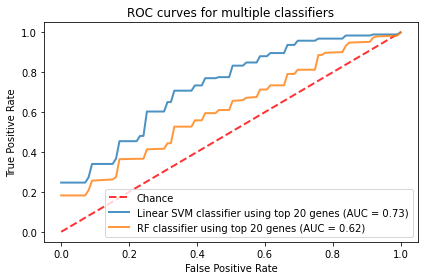

In [372]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_20, axis=0), np.mean(tprs_RF_20, axis=0))), 
                              np.array([np.mean(aucs_SVM_20), np.mean(aucs_RF_20)]), 
                              np.array(['Linear SVM classifier using top 20 genes', 'RF classifier using top 20 genes']))

top 50 genes

In [373]:
X2_50_train = X2_train.loc[:, top_50_genes].values
X2_50_test = X2_test.loc[:, top_50_genes].values

In [378]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X2_50_train, y2_train, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# step4: 打印结果
print(best)

100%|██████████| 100/100 [02:05<00:00,  1.26s/trial, best loss: 0.22610144390966302]
{'C': 1.4554534672517205, 'gamma': 0, 'kernel': 0, 'probability': 0}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

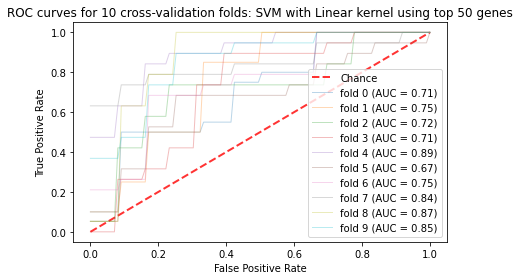

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

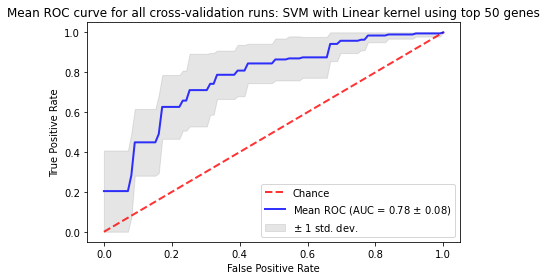

In [379]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_50 = svm.SVC(C = 1.4554534672517205, kernel='linear', probability=True, gamma='scale', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_50, f1_scores_SVM_50, tprs_SVM_50, aucs_SVM_50 = evaluate_classifier(folds=10, 
                                                                        p=X2_50_test, t=y2_test, 
                                                                        classifier=SVM_classifier_50, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_50, aucs_SVM_50, 'SVM with Linear kernel using top 50 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_50, aucs_SVM_50, 'SVM with Linear kernel using top 50 genes')

In [376]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_50 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_50, X2_50_train, y2_train, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X2_50_train,y2_train)

100%|██████████| 80/80 [04:28<00:00,  3.35s/trial, best loss: -0.697611995557201] 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

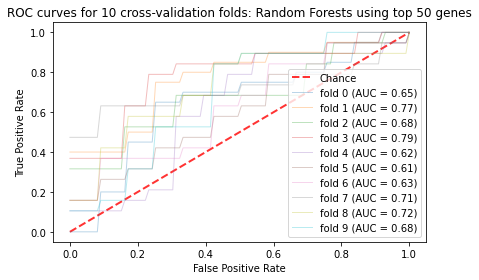

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

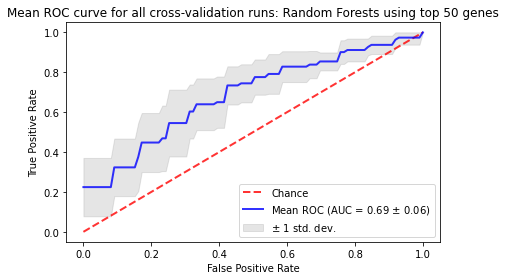

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


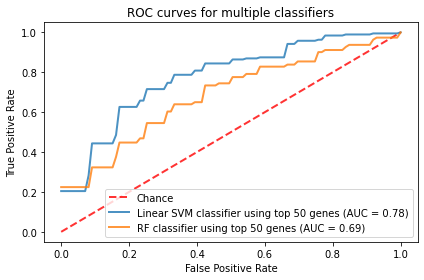

In [377]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_50, f1_scores_RF_50, tprs_RF_50, aucs_RF_50 = evaluate_classifier(folds=10, 
                                                                        p=X2_50_test, t=y2_test, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_50, aucs_RF_50, 'Random Forests using top 50 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_50, aucs_RF_50, 'Random Forests using top 50 genes')

plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_50, axis=0), np.mean(tprs_RF_50, axis=0))), 
                              np.array([np.mean(aucs_SVM_50), np.mean(aucs_RF_50)]), 
                              np.array(['Linear SVM classifier using top 50 genes', 'RF classifier using top 50 genes']))

top 100 genes

In [380]:
X2_100_train = X2_train.loc[:, top_100_genes].values
X2_100_test = X2_test.loc[:, top_100_genes].values

In [381]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X2_100_train, y2_train, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# step4: 打印结果
print(best)

100%|██████████| 100/100 [03:36<00:00,  2.16s/trial, best loss: 0.175694187338023]
{'C': 9.93161989756103, 'gamma': 1, 'kernel': 1, 'probability': 0}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

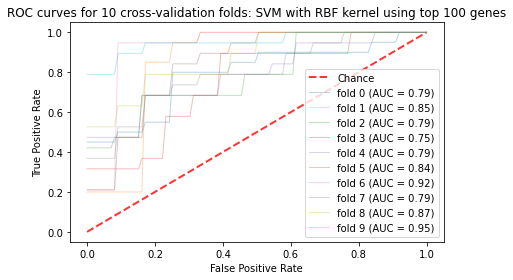

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

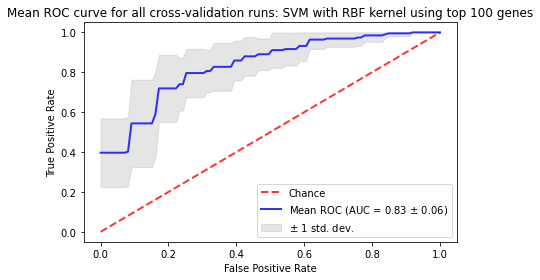

In [385]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_100 = svm.SVC(C = 9.93161989756103, kernel='rbf', probability=True, gamma='auto', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_100, f1_scores_SVM_100, tprs_SVM_100, aucs_SVM_100 = evaluate_classifier(folds=10, 
                                                                        p=X2_100_test, t=y2_test, 
                                                                        classifier=SVM_classifier_100, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_100, aucs_SVM_100, 'SVM with RBF kernel using top 100 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_100, aucs_SVM_100, 'SVM with RBF kernel using top 100 genes')

In [383]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_100 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_100, X2_100_train, y2_train, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X2_100_train,y2_train)

100%|██████████| 80/80 [04:07<00:00,  3.10s/trial, best loss: -0.718067382450944] 


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

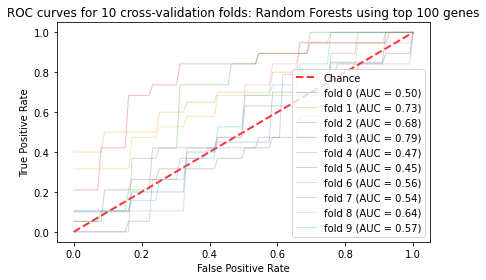

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

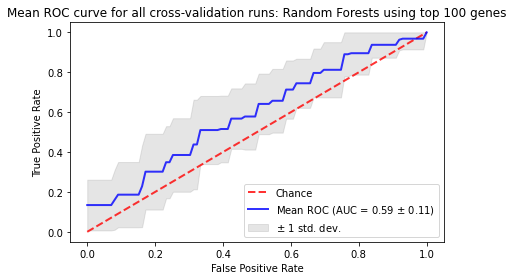

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


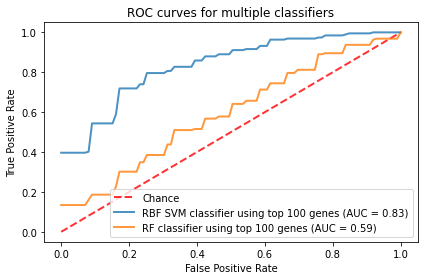

In [384]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_100, f1_scores_RF_100, tprs_RF_100, aucs_RF_100 = evaluate_classifier(folds=10, 
                                                                        p=X2_100_test, t=y2_test, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_100, aucs_RF_100, 'Random Forests using top 100 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_100, aucs_RF_100, 'Random Forests using top 100 genes')

plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_100, axis=0), np.mean(tprs_RF_100, axis=0))), 
                              np.array([np.mean(aucs_SVM_100), np.mean(aucs_RF_100)]), 
                              np.array(['RBF SVM classifier using top 100 genes', 'RF classifier using top 100 genes']))

Comparison Between the Best Performing Models

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

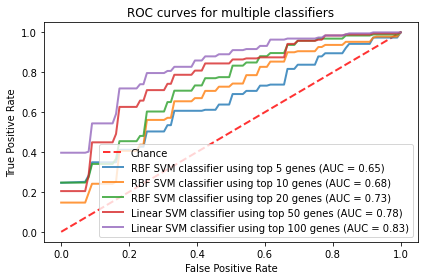

In [389]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_5, axis=0), np.mean(tprs_SVM_10, axis=0), np.mean(tprs_SVM_20, axis=0), np.mean(tprs_SVM_50, axis=0), np.mean(tprs_SVM_100, axis=0))), 
                              np.array([np.mean(aucs_SVM_5), np.mean(aucs_SVM_10), np.mean(aucs_SVM_20), np.mean(aucs_SVM_50), np.mean(aucs_SVM_100)]), 
                              np.array(['RBF SVM classifier using top 5 genes', 'RBF SVM classifier using top 10 genes', 'RBF SVM classifier using top 20 genes', 'Linear SVM classifier using top 50 genes', 'Linear SVM classifier using top 100 genes']))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

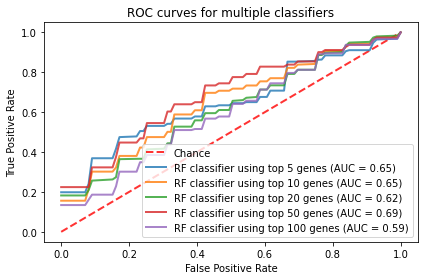

In [390]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_RF_5, axis=0), np.mean(tprs_RF_10, axis=0), np.mean(tprs_RF_20, axis=0), np.mean(tprs_RF_50, axis=0), np.mean(tprs_RF_100, axis=0))), 
                              np.array([np.mean(aucs_RF_5), np.mean(aucs_RF_10), np.mean(aucs_RF_20), np.mean(aucs_RF_50), np.mean(aucs_RF_100)]), 
                              np.array(['RF classifier using top 5 genes', 'RF classifier using top 10 genes', 'RF classifier using top 20 genes', 'RF classifier using top 50 genes', 'RF classifier using top 100 genes']))